In [1]:
import sys
sys.path.append("../src")

from preprocessing import *
from feature_extraction import *
from generate_heatmap import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
volunteer_ids = [f"S{n:03d}" for n in range(1,110)]
channel_ids = ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 
               'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 
               'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 
               'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 
               'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 
               'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 
               'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 
               'Oz', 'O2', 'Iz']
root_dir = '../data/files/'
result_dir = '../results/tmp/'

PLOTTING FOR FILTERED DATA CASE

In [3]:
results = []
for v in volunteer_ids:   
    r1, r2 = extract_data(v, root_dir)
    r1, r2 = filter_data(r1, r2)

    labels = r1.ch_names
    label_idx = {label: idx for idx, label in enumerate(labels)}

    r1_data = r1.get_data()
    r2_data = r2.get_data()

    for ch in channel_ids:
        idx = label_idx[ch]
        signal1 = r1_data[idx,:]
        signal2 = r2_data[idx,:]
        
        etc_1 = etc_func(signal1)
        etc_2 = etc_func(signal2)

        results.append({
            'volunteer': v,
            'channel': ch,
            'ETC_EyesOpen': etc_1,
            'ETC_EyesClosed': etc_2,
            })
data_filtered = pd.DataFrame(results)
%store data_filtered

Stored 'data_filtered' (DataFrame)


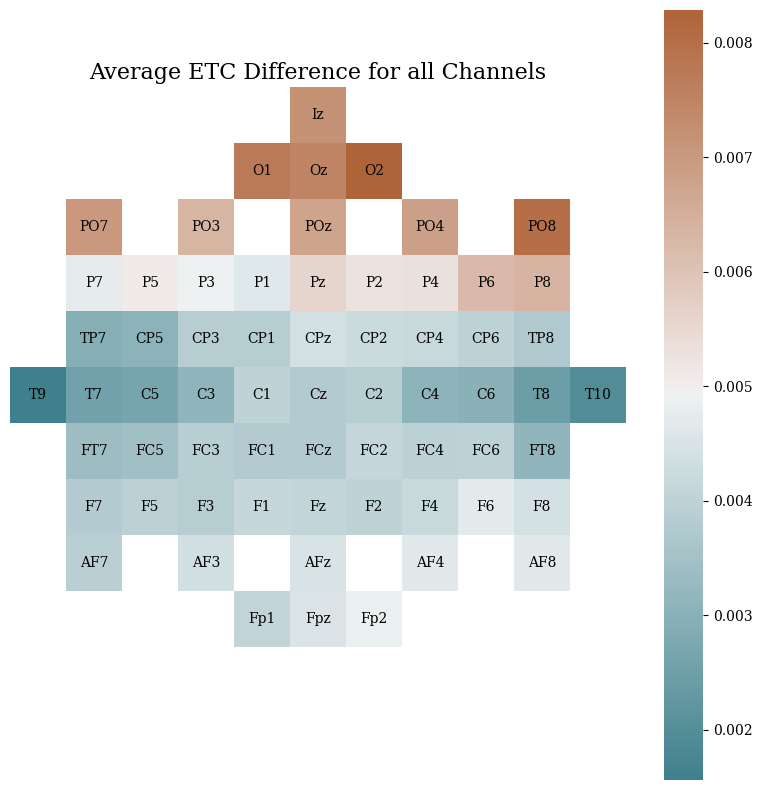

In [4]:
plot_heatmap(data_filtered, result_dir)

PLOTTING FOR UNFILTERED CASE

In [5]:
results = []
for v in volunteer_ids:  
    r1, r2 = extract_data(v, root_dir)
    
    labels = r1.ch_names
    label_idx = {label: idx for idx, label in enumerate(labels)}
 
    r1_data = r1.get_data()
    r2_data = r2.get_data()

    for ch in channel_ids:
        idx = label_idx[ch]
        signal1 = r1_data[idx,:]
        signal2 = r2_data[idx,:]
        
        etc_1 = etc_func(signal1)
        etc_2 = etc_func(signal2)

        results.append({
            'volunteer': v,
            'channel': ch,
            'ETC_EyesOpen': etc_1,
            'ETC_EyesClosed': etc_2,
            })
data_unfiltered = pd.DataFrame(results)
%store data_unfiltered

Stored 'data_unfiltered' (DataFrame)


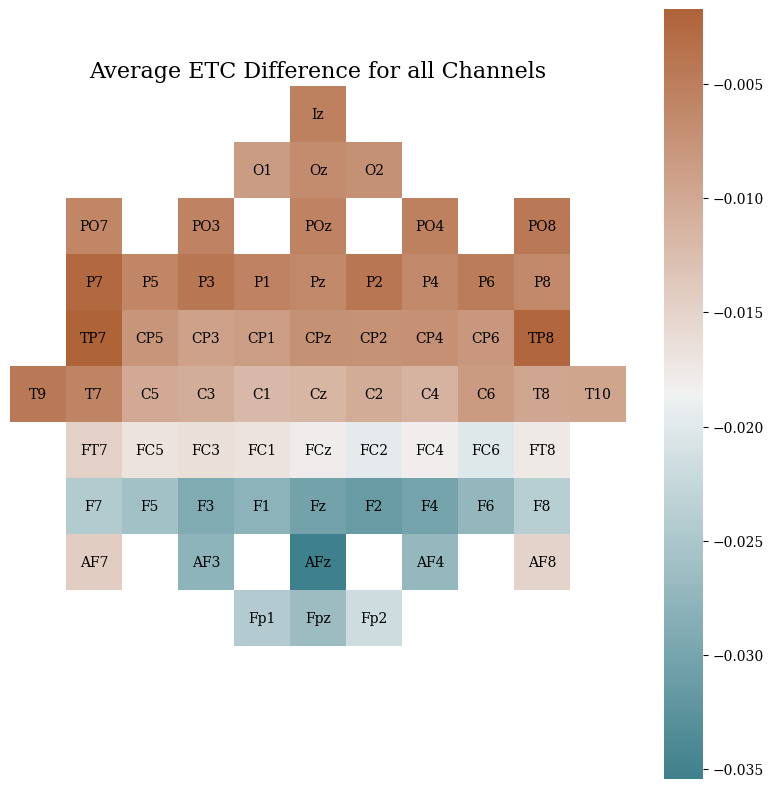

In [6]:
plot_heatmap(data_unfiltered, result_dir)